# Preprocessing Time-Series

### Libraries

In [42]:
import numpy as np
import pandas as pd

# Viz
import matplotlib.pyplot as plt

# Scipy
from scipy.stats import boxcox
from scipy.stats import normaltest

# Sklearn
from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.impute import SimpleImputer

# Datetime
import datetime
from datetime import date
import featuretools as ft
from featuretools.primitives import Minute, Hour, Day, Month, Year, Weekday

### Transformations

Log and Power Transformations in Practice

In [2]:
np.random.seed(0)

In [3]:
pts = 10000
vals = np.random.lognormal(0, 1.0, pts)

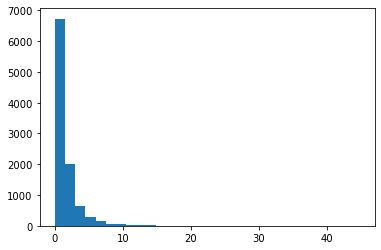

In [4]:
_, ax = plt.subplots()
ax.hist(vals, bins=30)
plt.show()

In [5]:
# Standardize data.
scaler = StandardScaler()
vals_ss = scaler.fit_transform(vals.reshape(-1,1))

Null hypothesis of `normaltest` is that the sample is from a normal distribution. P-value less than or equal to 0.05 allows reject the null hypothesis.

In [6]:
# Check if a normal distribution.
_, p = normaltest(vals_ss)
print(f"Significance: {p[0]:.2f}") # Not normal.

Significance: 0.00


In [7]:
vals_mm = minmax_scale(vals)
_, p = normaltest(vals_mm.squeeze())
print(f"Significance: {p:.2f}") # Not normal.

Significance: 0.00


Text(0.5, 0, 'Unscaled')

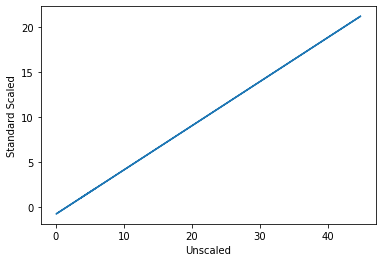

In [8]:
plt.plot(vals, vals_ss)
plt.ylabel("Standard Scaled")
plt.xlabel("Unscaled")

In [9]:
# Log-transformation
log_transformed = np.log(vals)
_, p = normaltest(log_transformed)
print(f"significance: {p:.2f}") 

significance: 0.46


Can't reject the null hypothesis, this distribution is normal.

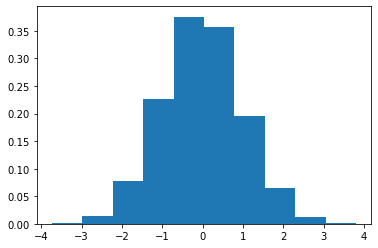

In [10]:
_ = plt.hist(log_transformed, density=True)

$
BoxCox = \left\{
    \begin{array}{}
        \frac{\left(x^{\lambda} - 1\right)}{\lambda} & \lambda != 0 \\
        log\left(x \right) & \lambda = 0
    \end{array}
\right.
$

In [11]:
# Box Cox transformation.
vals_bc = boxcox(vals, lmbda=0.0)
_, p = normaltest(vals_bc)
print(f"Significance: {p:.2f}") # Can't reject nulll hypothesis.

Significance: 0.46


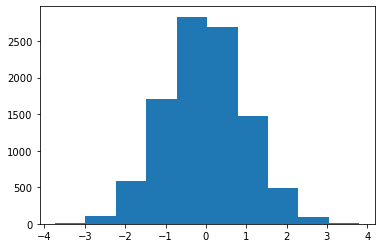

In [12]:
_ = plt.hist(vals_bc)

Imputation

In [15]:
imp_mean = SimpleImputer(strategy="mean")
imp_mean.fit([[7, 2, 3], [4, np.nan, 6], [10, 5, 9]])
df = [[np.nan, 2, 3], [4, np.nan, 6], [10, np.nan, 9]]
print(imp_mean.transform(df))

[[ 7.   2.   3. ]
 [ 4.   3.5  6. ]
 [10.   3.5  9. ]]


Holiday Features

In [17]:
from workalendar.africa.kenya import Kenya
Kenya().holidays()

c:\Users\moses\Anaconda3\lib\site-packages\workalendar\core.py:436: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '


[(datetime.date(2023, 1, 1), 'New year'),
 (datetime.date(2023, 1, 2), 'New year Shift'),
 (datetime.date(2023, 2, 11), 'Moi Memorial Day'),
 (datetime.date(2023, 4, 7), 'Good Friday'),
 (datetime.date(2023, 4, 10), 'Easter Monday'),
 (datetime.date(2023, 4, 22), 'Eid al-Fitr'),
 (datetime.date(2023, 5, 1), 'Labour Day'),
 (datetime.date(2023, 6, 1), 'Madaraka Day'),
 (datetime.date(2023, 6, 29), 'Eid al-Adha'),
 (datetime.date(2023, 10, 10), 'Huduma Day'),
 (datetime.date(2023, 10, 20), 'Mashujaa Day'),
 (datetime.date(2023, 12, 12), 'Jamhuri Day'),
 (datetime.date(2023, 12, 25), 'Christmas Day'),
 (datetime.date(2023, 12, 26), 'Utamaduni Day'),
 (datetime.date(2023, 12, 31), 'New Years Eve'),
 (datetime.date(2024, 1, 1), 'New Years Eve Shift')]

Date Annotations

In [20]:
import calendar
calendar.monthrange(2023, 3)

(2, 31)

In [25]:
calendar.monthrange?

Signature: calendar.monthrange(year, month)
Docstring:
Return weekday (0-6 ~ Mon-Sun) and number of days (28-31) for
year, month.
File:      c:\users\moses\anaconda3\lib\calendar.py
Type:      function


Season

In [33]:
YEAR = 2023
today = datetime.date(2021, 4, 11)

# ----

seasons = [
 ('first_wet', (date(YEAR, 3, 2), date(YEAR, 5, 31))),
 ('second_wet', (date(YEAR, 9, 1), date(YEAR, 12, 24))),
 ('first_dry', (date(YEAR, 12, 25), date(YEAR, 3, 1))),
 ('second_dry', (date(YEAR, 6, 1), date(YEAR, 8, 31)))
]
seasons

[('first_wet', (datetime.date(2023, 3, 2), datetime.date(2023, 5, 31))),
 ('second_wet', (datetime.date(2023, 9, 1), datetime.date(2023, 12, 24))),
 ('first_dry', (datetime.date(2023, 12, 25), datetime.date(2023, 3, 1))),
 ('second_dry', (datetime.date(2023, 6, 1), datetime.date(2023, 8, 31)))]

In [34]:
def is_in_interval(current_date: datetime.date, seasons):
      return next(season for season, (start, end) in seasons
                if start <= current_date.replace(year=YEAR) <= end)
    
is_in_interval(today, seasons)

'first_wet'

Automated Feature Extraction

In [59]:
data = pd.DataFrame(
 {'Time': ['2014-01-01 01:41:50',
 '2014-01-01 02:06:50',
 '2014-01-01 02:31:50',
 '2014-01-01 02:56:50',
 '2014-01-01 03:21:50'],
 'Target': [1, 2, 3, 4, 5]}
)
data

,Time,Target
0,2014-01-01 01:41:50,1
1,2014-01-01 02:06:50,2
2,2014-01-01 02:31:50,3
3,2014-01-01 02:56:50,4
4,2014-01-01 03:21:50,5


In [60]:
data['index'] = data.index
es = ft.EntitySet("My EntitySet")

In [61]:

# es = ft.EntitySet('My EntitySet')
# es.entity_from_dataframe(
#     entity_id='main_data_table',
#     index='index',
#     dataframe=data,
#     time_index='Time'
# )
# fm, features = ft.dfs(
#     entityset=es, 
#     target_entity='main_data_table', 
#     trans_primitives=[Minute, Hour, Day, Month, Year, Weekday]
# )

In [62]:
from tsfresh.feature_extraction import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters
settings = ComprehensiveFCParameters()

In [63]:
settings = ComprehensiveFCParameters()
tsfresh_features = extract_features(data, column_id='Time', default_fc_parameters=settings)

Feature Extraction: 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]


In [68]:
tsfresh_features['Target__sum_values']

2014-01-01 01:41:50    1.0
2014-01-01 02:06:50    2.0
2014-01-01 02:31:50    3.0
2014-01-01 02:56:50    4.0
2014-01-01 03:21:50    5.0
Name: Target__sum_values, dtype: float64

ROCKET

In [71]:
from sktime.datasets import load_arrow_head
from sktime.datatypes import convert_to

In [72]:
X_train, y_train = load_arrow_head(split="train", return_X_y=True)

In [88]:
X_train.iloc[0].squeeze().shape

(251,)

In [94]:
print(X_train.shape)
print(f"Unnested: {convert_to(X_train, to_type='numpyflat').shape}")

(36, 1)
Unnested: (36, 251)


In [98]:
from sktime.transformations.panel.rocket import Rocket
rocket = Rocket(num_kernels=1000)
rocket.fit(X_train)
X_train_transform = rocket.transform(X_train)

In [100]:
X_train_transform.shape

(36, 2000)

In [108]:
X_train_transform.loc[:0, :5]

,0,1,2,3,4,5
0,0.793103,3.982605,0.352941,1.356429,0.677291,5.136731


In [112]:
X_train.loc[:0, ['dim_0']]

,dim_0
0,0 -1.963009 1 -1.957825 2 -1.95614...


Shapelets in Practice

In [118]:
from sktime.transformations.panel.shapelet_transform import ShapeletTransform
shapelets_transform = ShapeletTransform()

In [120]:
# shapelets_transform.fit(X_train, y_train)